<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [2]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2019-12-25 12:31:44--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.002s  

2019-12-25 12:31:44 (14.1 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object 

In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [7]:
# notice: installing seaborn might takes a few minutes
#!conda install -c anaconda seaborn -y

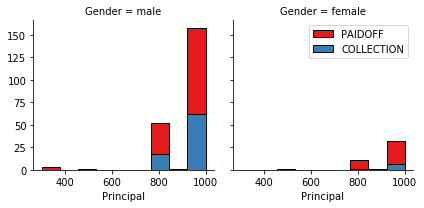

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

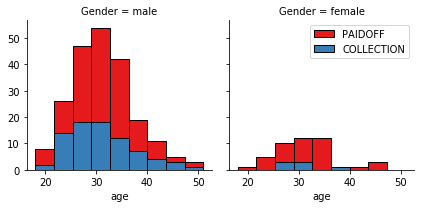

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

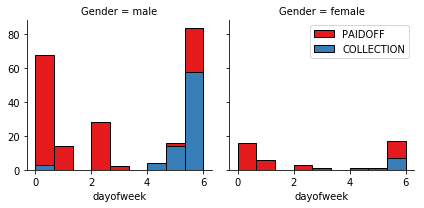

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [15]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [16]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [17]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [18]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [19]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [20]:
#Split test and train sets

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


In [21]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

#Iterations to find the best K

K = 20
m_acc = np.zeros(K)
F1 = np.zeros(K)
CM_tp = np.zeros(K)
CM_tn = np.zeros(K)
J = np.zeros(K)
max_acc = 0

for i in range(1,K):
    neigh = KNeighborsClassifier(n_neighbors = i).fit(X_train,y_train)
    yhat = neigh.predict(X_test)
    
#measuring accuracy
    m_acc[i] = metrics.accuracy_score(y_test,yhat)

#When the program finds the classifier with the highest accuracy,
#saves it in the variable K_bestPred

    if m_acc[i] > max_acc:
        K_bestPred = neigh
        max_acc = m_acc[i]
        
    
m_acc 

array([0.        , 0.67142857, 0.65714286, 0.71428571, 0.68571429,
       0.75714286, 0.71428571, 0.78571429, 0.75714286, 0.75714286,
       0.67142857, 0.7       , 0.72857143, 0.7       , 0.7       ,
       0.68571429, 0.72857143, 0.72857143, 0.72857143, 0.7       ])

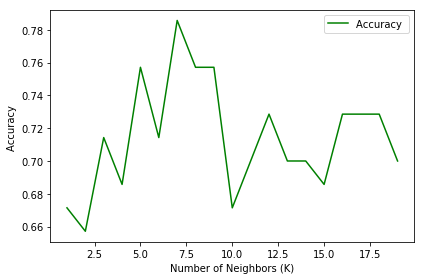

The best accuracy was with 0.7857142857142857 with k= 7


In [22]:
#Plotting accuracy for diferent K's

plt.plot(range(1,K),m_acc[1:K],'g')
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

print( "The best accuracy was with", m_acc.max(), "with k=", m_acc.argmax())

The best model achieved for this experiment using the accuracy_score function, was the one with K=7.

Here we can see that increasing the number of K's not always result in a better performance of the predictor, in this case, as the number of K's gets close to 20 the accuracy decreases.

Now, to evaluate the performance of the classification, the confusion matrix is plotted for the best model:

In [72]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

K_besty = K_bestPred.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test,K_besty))
print (classification_report(y_test, K_besty))


Confusion Matrix:
[[ 6  9]
 [ 6 49]]
              precision    recall  f1-score   support

  COLLECTION       0.50      0.40      0.44        15
     PAIDOFF       0.84      0.89      0.87        55

   micro avg       0.79      0.79      0.79        70
   macro avg       0.67      0.65      0.66        70
weighted avg       0.77      0.79      0.78        70



Using the confusion matrix, we get that 89% (49 out of 55) of the values were correctly classified as 'PAIDOFF', but just 40% (6 out of 15) were correctly classified as 'COLLECTION'. 

# Decision Tree

In [24]:
#Split test and train sets

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


To get the best model, the max depth attribute is going to change for each iteration from 1 to 10.

Max_depth: Controls the maximum depth of the tree that will be created. It can also be described as the length of the longest path from the tree root to a leaf. The root node is considered to have a depth of 0. (Source: https://infocenter.informationbuilders.com/wf80/index.jsp?topic=%2Fpubdocs%2FRStat16%2Fsource%2Ftopic47.htm)

In [25]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

depth = 20
acc = np.zeros(depth - 1)
CM_tp = np.zeros(depth - 1)
CM_tn = np.zeros(depth - 1)
F1 = np.zeros(depth - 1)
J = np.zeros(depth-1)
max_acc = 0

#iterations to find the best model
for i in range(1,depth):
    
    tree = DecisionTreeClassifier(criterion="entropy", max_depth = i)
    tree.fit(X_train, y_train)

    treePred = tree.predict(X_test)
    
    acc[i-1] = metrics.accuracy_score(y_test, treePred)
    
#When the program finds the classifier with the highest accuracy,
#saves it in the variable tree_bestPred
    if acc[i-1] > max_acc:
        tree_bestPred = tree
        max_acc = acc[i-1]
    
#Values of tn, tp, fn, fp gotten from the confusion matrix for each iteration
    tn, fp, fn, tp = confusion_matrix(y_test, treePred).ravel()
    
    CM_tp[i-1] = tp
    CM_tn[i-1]= tn

acc

array([0.78571429, 0.78571429, 0.61428571, 0.61428571, 0.64285714,
       0.77142857, 0.75714286, 0.75714286, 0.65714286, 0.7       ,
       0.7       , 0.71428571, 0.7       , 0.71428571, 0.72857143,
       0.68571429, 0.7       , 0.7       , 0.7       ])

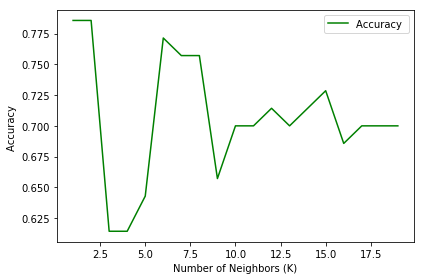

The best accuracy was with 0.7857142857142857 with k= 1


In [26]:
#Plotting accuracy for diferent K's

plt.plot(range(1,depth),acc,'g')
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

print( "The best accuracy was with", acc.max(), "with k=", acc.argmax() + 1)

In [27]:
#Notice:
#!conda install -c conda-forge pydotplus -y
#!conda install -c conda-forge python-graphviz -y


In [28]:
tree_besty = tree_bestPred.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test,tree_besty))


Confusion Matrix:
[[ 0 15]
 [ 0 55]]


Using the confusion matrix, we get that 100% (55 out of 55) of the values were correctly classified as 'PAIDOFF', but none of the ones that belong to the 'COLLECTION' class were classified right. That shows that even though the accuracy_score function gets a high value, the performance of the classifier is poor.

Looking deeper into the real-world problem and the dataset itself, it can be assumed that it is better to have more people correctly classified as 'COLLECTION' than people correctly classified as 'PAIDOFF'. So to get a more "balanced" classifier, look into the confusion matrix values (tp, tn, fp, fn) for each trained model, and calculate the F1 score, the accuracy measure that is directly related to the classification rate.

A value of max_depth=15 is chosen and the confusion matrix and F1-score is as follows:

In [29]:
#tp and tn values for each iteration
print(CM_tp)
print(CM_tn)

[55. 55. 36. 36. 35. 53. 52. 52. 40. 47. 48. 45. 42. 42. 43. 41. 42. 42.
 42.]
[ 0.  0.  7.  7. 10.  1.  1.  1.  6.  2.  1.  5.  7.  8.  8.  7.  7.  7.
  7.]


In [30]:
tree_bestPred1 = DecisionTreeClassifier(criterion = "entropy", max_depth = 15)
tree_bestPred1.fit(X_train, y_train)

tree_y1 = tree_bestPred1.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, tree_y1))

Confusion Matrix:
[[ 8  7]
 [11 44]]


In [71]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import classification_report

#accuracy
acc_ = metrics.accuracy_score(y_test, tree_y1)

#precision and recall for F1-score
tn, fp, fn, tp = confusion_matrix(y_test, tree_y1).ravel()
prec = tp/(tp+fp)
rec = tp/(tp+fn)

F1_ = 2*(prec*rec)/(prec+rec)
J_ = jaccard_similarity_score(y_test, tree_y1)

print("Accuracy =", acc_)
print("J =", J_)
print("F1 =", F1_)
print (classification_report(y_test, tree_y1))

Accuracy = 0.7428571428571429
J = 0.7428571428571429
F1 = 0.8301886792452831
              precision    recall  f1-score   support

  COLLECTION       0.42      0.53      0.47        15
     PAIDOFF       0.86      0.80      0.83        55

   micro avg       0.74      0.74      0.74        70
   macro avg       0.64      0.67      0.65        70
weighted avg       0.77      0.74      0.75        70



For this case, the model classified correctly 78% (43 out of 55) the 'PAIDOFF' class, and 53% (8 out of 15) people that belongs to the 'COLLECTION' class with an accuracy of 0.73 and a F1-score of 0.82

# Support Vector Machine

To get the best predictor, four models will be trained with four different kernel functions:

1. Linear
2. Polinomial
3. Radial basis function
4. Sigmoid

Accuracy will be compared to choose one optimal Support Vector Machine classifier for this particular problem and dataset

In [32]:
from sklearn import svm

#Linear function
VMlin = svm.SVC(kernel='linear')
VMlin.fit(X_train, y_train)

lin_yhat = VMlin.predict(X_test)
SVlin_acc = metrics.accuracy_score(y_test, lin_yhat)
lin_cm = confusion_matrix(y_test, lin_yhat)

#Polynomial function
VMpol = svm.SVC(kernel='poly')
VMpol.fit(X_train, y_train)

pol_yhat = VMpol.predict(X_test)
SVpol_acc = metrics.accuracy_score(y_test, pol_yhat)
pol_cm = confusion_matrix(y_test, pol_yhat)

#Radial basis function
VMrbf = svm.SVC(kernel='rbf')
VMrbf.fit(X_train, y_train)

rbf_yhat = VMrbf.predict(X_test)
SVrbf_acc = metrics.accuracy_score(y_test, rbf_yhat)
rbf_cm = confusion_matrix(y_test, rbf_yhat)

#Sigmoid function
VMsig = svm.SVC(kernel='sigmoid')
VMsig.fit(X_train, y_train)

sig_yhat = VMsig.predict(X_test)
SVsig_acc = metrics.accuracy_score(y_test, sig_yhat)
sig_cm = confusion_matrix(y_test, sig_yhat)

print("Accuracy and Confusion Matrix foreach trained model:")
print("Accuracy (Linear Function) =",SVlin_acc)
print(lin_cm)
print("Accuracy (Polynomial Function) =",SVpol_acc)
print(pol_cm)
print("Accuracy (Radial Basis Function) =",SVrbf_acc)
print(rbf_cm)
print("Accuracy (Sigmoid Function) =",SVsig_acc)
print(sig_cm)

Accuracy and Confusion Matrix foreach trained model:
Accuracy (Linear Function) = 0.7857142857142857
[[ 0 15]
 [ 0 55]]
Accuracy (Polynomial Function) = 0.7714285714285715
[[ 1 14]
 [ 2 53]]
Accuracy (Radial Basis Function) = 0.7428571428571429
[[ 4 11]
 [ 7 48]]
Accuracy (Sigmoid Function) = 0.7428571428571429
[[ 1 14]
 [ 4 51]]


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


According to the previously trained models, the one with the highest accuracy is the one with the linear kernel function.

To evaluate performance, a confusion matrix is built out of the prediction performed by the model.

In [33]:
confusion_matrix(y_test, lin_yhat)

array([[ 0, 15],
       [ 0, 55]])

Once again the classifier has a poorperfomance since it doesn't classifies any of the people that belong to the 'COLLECTION' class. By looking at the confusion matrices for each trained model, the one with the Radial Basis kernel function is chosen:

In [34]:
print("Confusion Matrix for Radial Basis Function")
print(confusion_matrix(y_test, rbf_yhat))


Confusion Matrix for Radial Basis Function
[[ 4 11]
 [ 7 48]]


It's shown that the RadialBasis Function model may have a better classification performance, 87% correctly classified for the 'PAIDOFF' class and 26% correctly classified for the 'COLLECTION' class.

In [70]:
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import classification_report

print("Jaccard =",jaccard_similarity_score(y_test, rbf_yhat))
print("F1 =",f1_score(y_test, rbf_yhat, average='weighted'))
print (classification_report(y_test, rbf_yhat))

Jaccard = 0.7428571428571429
F1 = 0.7275882012724117
              precision    recall  f1-score   support

  COLLECTION       0.36      0.27      0.31        15
     PAIDOFF       0.81      0.87      0.84        55

   micro avg       0.74      0.74      0.74        70
   macro avg       0.59      0.57      0.57        70
weighted avg       0.72      0.74      0.73        70



# Logistic Regression

For the logistic regression classifier, a model using 'liblinear' function is trained. To reduce overfitting effect, a value of C=0.001 is chosen.

In [63]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression(C=0.001, solver='liblinear').fit(X_train,y_train)

LR_yhat = LR.predict(X_test)
LR_yhat_prob = LR.predict_proba(X_test)
LR_yhat_prob

LR_yhat
confusion_matrix(y_test,LR_yhat)

array([[ 4, 11],
       [12, 43]])

In [69]:
from sklearn.metrics import log_loss

print("Jaccard =",jaccard_similarity_score(y_test, LR_yhat))
print("F1 =",f1_score(y_test, LR_yhat, average='weighted'))
print("Log-loss =", log_loss(y_test, LR_yhat_prob))
print (classification_report(y_test, LR_yhat))

Jaccard = 0.6714285714285714
F1 = 0.6752209022111361
Log-loss = 0.670867975563743
              precision    recall  f1-score   support

  COLLECTION       0.25      0.27      0.26        15
     PAIDOFF       0.80      0.78      0.79        55

   micro avg       0.67      0.67      0.67        70
   macro avg       0.52      0.52      0.52        70
weighted avg       0.68      0.67      0.68        70



# Model Evaluation using Test set

In [74]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [75]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2019-12-25 12:51:26--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2019-12-25 12:51:26 (214 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [76]:
#load csv
test_df = pd.read_csv('loan_test.csv')
test_df.head()

#data preprocessing
test_df['due_date'] = pd.to_datetime(df['due_date'])
test_df['effective_date'] = pd.to_datetime(df['effective_date'])


test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

df['dayofweek'] = df['effective_date'].dt.dayofweek

test_df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df.head()

#feature extraction
testFeature = test_df[['Principal','terms','age','Gender','weekend']]
testFeature = pd.concat([testFeature,pd.get_dummies(test_df['education'])], axis=1)
testFeature.drop(['Master or Above'], axis = 1,inplace=True)
testFeature.head()

testX = testFeature
testy = test_df['loan_status'].values

#normalization
testX= preprocessing.StandardScaler().fit(testX).transform(testX)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:27: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.


In [77]:
#k-Means algorythm
K_yhat_test = K_bestPred.predict(testX)

print("Confusion Matrix:")
print(confusion_matrix(testy,K_yhat_test))

print("Jaccard =",jaccard_similarity_score(testy, K_yhat_test))
print("F1 =",f1_score(testy, K_yhat_test, average='weighted'))

Confusion Matrix:
[[ 2 12]
 [ 5 35]]
Jaccard = 0.6851851851851852
F1 = 0.6453810131971051


In [78]:
#Decision tree
tree_yhat_test = tree_bestPred1.predict(testX)

print("Confusion Matrix:")
print(confusion_matrix(testy,tree_yhat_test))

print("Jaccard =",jaccard_similarity_score(testy, tree_yhat_test))
print("F1 =",f1_score(testy, tree_yhat_test, average='weighted'))

Confusion Matrix:
[[ 7  7]
 [16 24]]
Jaccard = 0.5740740740740741
F1 = 0.5988805707115566


In [79]:
#Support Vector Machine

VM_yhat_test = VMrbf.predict(testX)

print("Confusion Matrix:")
print(confusion_matrix(testy,VM_yhat_test))

print("Jaccard =",jaccard_similarity_score(testy, VM_yhat_test))
print("F1 =",f1_score(testy, VM_yhat_test, average='weighted'))

Confusion Matrix:
[[ 5  9]
 [ 1 39]]
Jaccard = 0.8148148148148148
F1 = 0.7861952861952862


In [82]:
#Logistic Regression

LR_yhat_test = LR.predict(testX)
LR_yhat_probt = LR.predict_proba(testX)

print("Confusion Matrix:")
print(confusion_matrix(testy,LR_yhat_test))

print("Jaccard =",jaccard_similarity_score(testy, LR_yhat_test))
print("F1 =",f1_score(testy, LR_yhat_test, average='weighted'))
print("Log-loss =", log_loss(testy, LR_yhat_probt))

Confusion Matrix:
[[ 0 14]
 [ 0 40]]
Jaccard = 0.7407407407407407
F1 = 0.6304176516942475
Log-loss = 0.6744762743311654


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | 0.685   | 0.645    | NA      |
| Decision Tree      | 0.555   | 0.582    | NA      |
| SVM                | 0.815   | 0.786    | NA      |
| LogisticRegression | 0.740   | 0.630    | 0.674   |

According to the table, the best classifier obtained for the problem and the particular database was the support vector machine predictor.

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>